# Machine Learning : Trending YouTube videos

Machine learning with 'sklearn' and scalable machine learning with 'Spark' ML!



In [46]:
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import random 
# import rey
import os

%matplotlib inline

In [2]:

%%capture
!pip3 install boto3

In [3]:
# Data loading
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('penn-cis545-files').download_file('youtube_data.zip', 'youtube_data.zip')

!unzip /content/youtube_data.zip

Archive:  /content/youtube_data.zip
   creating: youtube_data/
  inflating: youtube_data/IN_category_id.json  
   creating: __MACOSX/
   creating: __MACOSX/youtube_data/
  inflating: __MACOSX/youtube_data/._IN_category_id.json  
  inflating: youtube_data/.DS_Store  
  inflating: __MACOSX/youtube_data/._.DS_Store  
  inflating: youtube_data/FR_category_id.json  
  inflating: __MACOSX/youtube_data/._FR_category_id.json  
  inflating: youtube_data/INvideos.csv  
  inflating: __MACOSX/youtube_data/._INvideos.csv  
  inflating: youtube_data/CAvideos.csv  
  inflating: __MACOSX/youtube_data/._CAvideos.csv  
  inflating: youtube_data/FRvideos.csv  
  inflating: __MACOSX/youtube_data/._FRvideos.csv  
  inflating: youtube_data/CA_category_id.json  
  inflating: __MACOSX/youtube_data/._CA_category_id.json  
  inflating: youtube_data/US_category_id.json  
  inflating: __MACOSX/youtube_data/._US_category_id.json  
  inflating: youtube_data/USvideos.csv  
  inflating: __MACOSX/youtube_data/._USvide

## Data loading and Preprocessing 

Dataset : a daily record of the top trending YouTube videos.

To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). 

This dataset includes several months (and counting) of data on daily trending YouTube videos, with up to 200 listed trending videos per day,in numerous countries.

__Each region’s data (csv):__

*   Video Title
*   Channel title
*   Publish time
*   Tags
*   Views
*   Likes
*   Dislikes
*   Description
*   Comment count

__category\_id__ field in the associated JSON. 




#### Combining Multiple CSV's

- Combine csv files into a single dataframe (join on 'video_id')

While combining them, create a column for "country" and fill it in the final dataframe. The country name is extracted using the filename itself.



In [4]:
# Import all the csv files / glob.glob for handling multi files

files = [i for i in glob.glob('/content/youtube_data/*.csv'.format('csv'))]  
sorted(files)

# Combine all into a single dataframe 
all_dataframes = list()

for csv in files:
  country_csv = pd.read_csv(csv,index_col='video_id')
  country_csv['country']= csv.split('/')[3][:2] # add 'country' column 
  # print(csv)
  all_dataframes.append(country_csv)
combined_data = pd.concat(all_dataframes)


combined_data.columns

Index(['trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'country'],
      dtype='object')

In [5]:

combined_data.head(3)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,
Ro6eob0LrCY,17.14.11,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...,FR
Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...,FR
ceqntSXE-10,17.14.11,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...,FR


#### Map category Id to category 

Read the category_id.json file and map the category_id's in the dataframe to the category name.


In [6]:
combined_data['category_id'] = combined_data['category_id'].astype(str) 

# JSON file to dataframe
with open('/content/youtube_data/US_category_id.json', "r") as id_json:
    category_json = json.load(id_json)
    # print(category_json)

id_dict ={}
for item in category_json['items']:
    
  id_dict[item['id']] = item["snippet"]['title'] # e.x : no. 1= 'Film & Animation'

combined_data['category'] = combined_data['category_id'].copy()
combined_data['category'].replace(id_dict, inplace = True)

combined_data.head(5)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category
video_id,,,,,,,,,,,,,,,,,
Ro6eob0LrCY,17.14.11,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...,FR,Entertainment
Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...,FR,Entertainment
ceqntSXE-10,17.14.11,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...,FR,Comedy
WuTFI5qftCE,17.14.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o...",FR,Gaming
ee6OFs8TdEg,17.14.11,QUI SAUTERA LE PLUS HAUT ? (VÉLO SKATE ROLLER ...,Aurelien Fontenoy,17,2017-11-13T16:30:03.000Z,"vélo""|""vtt""|""bmx""|""freestyle""|""bike""|""mtb""|""di...",141695,8091,72,481,https://i.ytimg.com/vi/ee6OFs8TdEg/default.jpg,False,False,False,Sauts à plus de 4 mètres de haut dans un tramp...,FR,Sports


#### Fix datetime format and remove rows with NA's 



In [7]:

combined_data['trending_date'] = pd.to_datetime(combined_data['trending_date'],format='%y.%d.%m')
combined_data['publish_time'] = pd.to_datetime(combined_data['publish_time'], format='%Y-%m-%d %H:%M:%S')

combined_data= combined_data.dropna()
combined_data.head(5) 


,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category
video_id,,,,,,,,,,,,,,,,,
Ro6eob0LrCY,2017-11-14,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13 17:32:55+00:00,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...,FR,Entertainment
Yo84eqYwP98,2017-11-14,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12 15:00:02+00:00,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...,FR,Entertainment
ceqntSXE-10,2017-11-14,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13 17:00:38+00:00,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...,FR,Comedy
WuTFI5qftCE,2017-11-14,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12 17:00:02+00:00,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o...",FR,Gaming
ee6OFs8TdEg,2017-11-14,QUI SAUTERA LE PLUS HAUT ? (VÉLO SKATE ROLLER ...,Aurelien Fontenoy,17,2017-11-13 16:30:03+00:00,"vélo""|""vtt""|""bmx""|""freestyle""|""bike""|""mtb""|""di...",141695,8091,72,481,https://i.ytimg.com/vi/ee6OFs8TdEg/default.jpg,False,False,False,Sauts à plus de 4 mètres de haut dans un tramp...,FR,Sports


## EDA and Feature Engineering 



#### simple statistics 

In [8]:
eda_described = combined_data.describe()
eda_sum = eda_described[['views',"likes",'dislikes','comment_count']]
eda_sum

,views,likes,dislikes,comment_count
count,1.545670e+05,1.545670e+05,1.545670e+05,1.545670e+05
mean,1.281578e+06,4.096105e+04,2.056138e+03,4.606594e+03
std,4.605292e+06,1.521490e+05,1.825854e+04,2.327823e+04
min,2.230000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.574900e+04,1.321000e+03,8.100000e+01,1.720000e+02
50%,3.134280e+05,6.336000e+03,2.980000e+02,7.650000e+02
75%,9.473390e+05,2.594050e+04,1.024000e+03,2.726000e+03
max,2.252119e+08,5.613827e+06,1.643059e+06,1.228655e+06


####  Rescale features (log scale)

Range of data rescaled to log scale (base e) and stored as likes_log, views_log, dislikes_log and comment_log. 

In [9]:
# Rescale features
import math
combined_data['likes_log'] = combined_data['likes'].apply(lambda x: math.log(x+1))
combined_data['views_log'] = combined_data['views'].apply(lambda x: math.log(x+1))
combined_data['dislikes_log'] = combined_data['dislikes'].apply(lambda x: math.log(x+1))
combined_data['comment_log'] = combined_data['comment_count'].apply(lambda x: math.log(x+1))



#### Plot the distribution


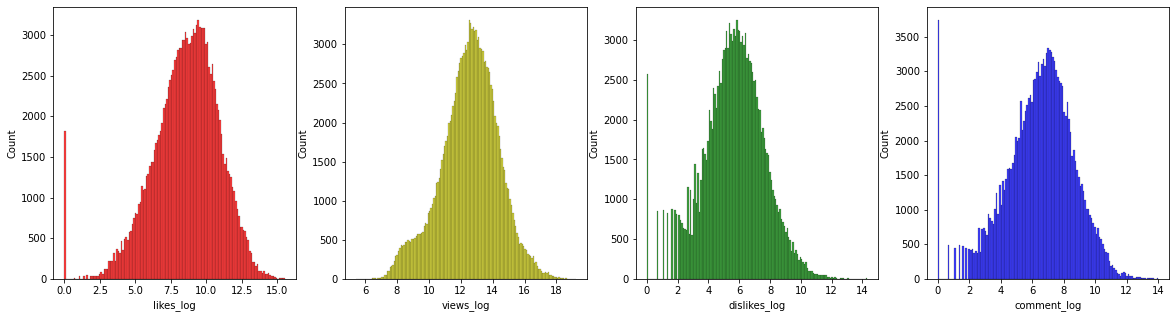

In [10]:

fig, ax =plt.subplots(1,4,figsize=(20,5))
likes_log =sns.histplot(combined_data['likes_log'],color='r',ax=ax[0])
views_log =sns.histplot(combined_data['views_log'],color='y',ax=ax[1])
dislikes_log =sns.histplot(combined_data['dislikes_log'],color='g',ax=ax[2])
comment_log =sns.histplot(combined_data['comment_log'],color='b',ax=ax[3])

fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


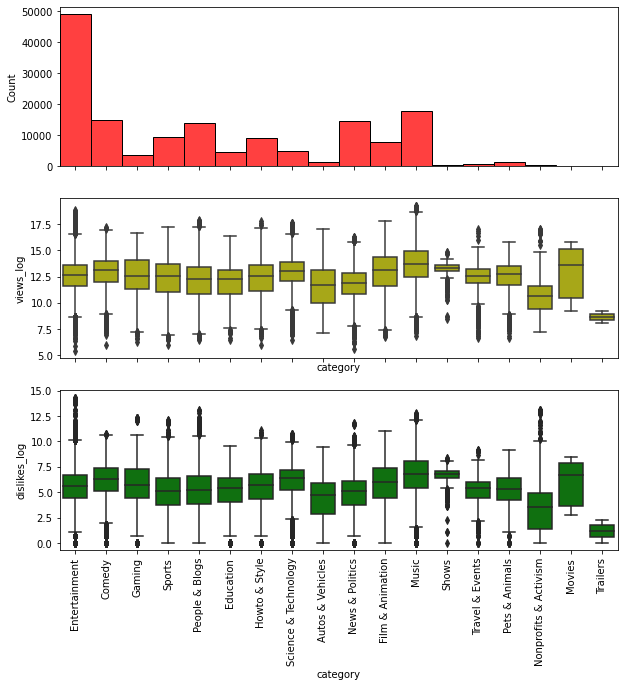

In [11]:

fig, ax =plt.subplots(3,1,figsize=(10,10), sharex=True)

category =sns.histplot(combined_data['category'],color='r',ax=ax[0])
views_log_cat =sns.boxplot(combined_data['category'], combined_data['views_log'],color='y',ax=ax[1])
dislikes_log_cat =sns.boxplot(combined_data['category'], combined_data['dislikes_log'],color='g',ax=ax[2])
plt.xticks(rotation=90)
fig.show()

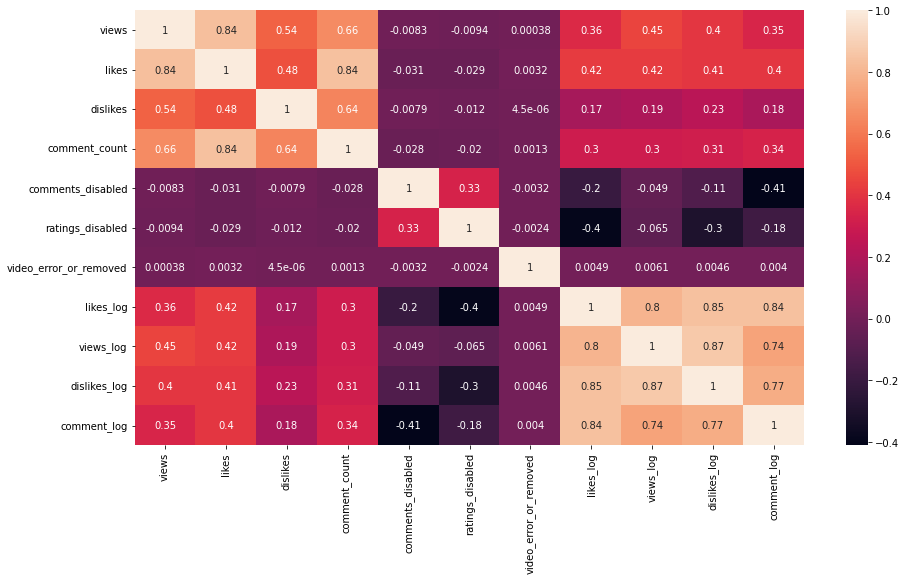

In [12]:
corr_matrix = combined_data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Feature Engineering 



##### Processing tags/description/title 

 - create a feature ['num_tags'] by counting numbers of ['tags']
 - Compute the length of description and title and add them as features to the dataset

In [13]:

combined_data["num_tags"] = combined_data['tags'].apply(lambda x: len(x.split('|')))
combined_data["desc_len"]=combined_data['description'].apply(lambda x: len(x))
combined_data["len_title"]=combined_data['title'].apply(lambda x: len(x))


combined_data["num_tags"]

video_id
Ro6eob0LrCY     6
Yo84eqYwP98     1
ceqntSXE-10     5
WuTFI5qftCE     8
ee6OFs8TdEg    24
               ..
1PhPYr_9zRY    27
BZt0qjTWNhw    14
D6Oy4LfoqsU    24
oV0zkMe1K8s    22
ooyjaVdt-jA     4
Name: num_tags, Length: 154567, dtype: int64

##### Processing publish_time. 

Split 'publish_time' into time, date, and weekday, and date and weekday will store the corresponding date and weekday number respectively. (Start with 1 for Monday and end with 7 for Sunday.)

In [14]:

# combined_data.columns
pub_time = combined_data['publish_time'].copy()
combined_data['publish_time'] =pub_time.apply(lambda x: datetime.time(x))
combined_data['publish_date'] =pub_time.apply(lambda x: datetime.date(x))

# #day on which video was published
combined_data['publish_weekday']= pub_time.apply(lambda x: datetime.weekday(x)+1)

random_index = np.random.randint(0,combined_data.shape[0]-1)


In [15]:
combined_data[['publish_time','publish_date','publish_weekday']]


,publish_time,publish_date,publish_weekday
video_id,,,
Ro6eob0LrCY,17:32:55,2017-11-13,1
Yo84eqYwP98,15:00:02,2017-11-12,7
ceqntSXE-10,17:00:38,2017-11-13,1
WuTFI5qftCE,17:00:02,2017-11-12,7
ee6OFs8TdEg,16:30:03,2017-11-13,1
...,...,...,...
1PhPYr_9zRY,16:39:29,2018-05-18,5
BZt0qjTWNhw,13:00:04,2018-05-18,5
D6Oy4LfoqsU,17:34:22,2018-05-18,5


##### Number of videos per weekday 

Compute the number of videos published per day of the week. 

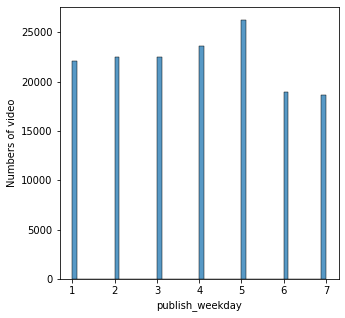

In [16]:

plt.figure(figsize=(5, 5));
num_videos= sns.histplot(combined_data['publish_weekday']);
plt.xlabel('publish_weekday');
plt.ylabel('Numbers of video');

plt.show()

#### Dropping irrelevant non numeric columns 

Drop non-numeric columns 
Note that a few key columns are non-numeric but should be kept in the dataframe:
comments_disabled, ratings_disabled, video_error_or_removed, country

Drop original views, like, comments and dislikes 

In [17]:
combined_data.dtypes

trending_date             datetime64[ns]
title                             object
channel_title                     object
category_id                       object
publish_time                      object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
description                       object
country                           object
category                          object
likes_log                        float64
views_log                        float64
dislikes_log                     float64
comment_log                      float64
num_tags                           int64
desc_len                           int64
len_title                          int64
publish_date    

In [18]:
num_combined_data=combined_data.select_dtypes(exclude=object)
num_combined_data=num_combined_data.drop(columns={'views','likes','dislikes','comment_count','trending_date'})
num_combined_data.columns

Index(['comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'likes_log', 'views_log', 'dislikes_log', 'comment_log', 'num_tags',
       'desc_len', 'len_title', 'publish_weekday'],
      dtype='object')

In [19]:

key_combined_data=pd.concat([num_combined_data,combined_data.country,combined_data.category_id],axis=1)
key_combined_data.head(5)

,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,publish_weekday,country,category_id
video_id,,,,,,,,,,,,,
Ro6eob0LrCY,False,False,False,10.284762,12.267652,7.011214,8.247482,6,1412,40,1,FR,24
Yo84eqYwP98,False,False,False,9.550662,12.977851,6.357842,7.057898,1,1828,100,7,FR,24
ceqntSXE-10,False,False,False,11.241169,13.086019,6.169611,9.167537,5,338,55,1,FR,23
WuTFI5qftCE,False,False,False,11.350607,13.737790,6.311735,8.367300,8,170,31,7,FR,20
ee6OFs8TdEg,False,False,False,8.998631,11.861439,4.290459,6.177944,24,1384,58,1,FR,17


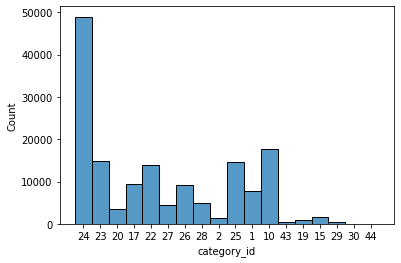

In [20]:
sns.histplot(key_combined_data['category_id'])

#### Convert categorical features into numeric (one hot vectors).


In [21]:

weekday_dummies=pd.get_dummies(key_combined_data.publish_weekday.astype('category'), prefix='weekday')
country_dummies=pd.get_dummies(key_combined_data.country.astype('category'),prefix='country')
category_dummies= pd.get_dummies(key_combined_data.category_id.astype('category'),prefix='category')

combined_data_dummies=pd.concat([key_combined_data, weekday_dummies,country_dummies,category_dummies], axis=1)
combined_data_dummies=combined_data_dummies.drop(columns={'publish_weekday','country','category_id'})

combined_data_dummies.head(5)

,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,country_CA,country_FR,country_IN,country_US,category_1,category_10,category_15,category_17,category_19,category_2,category_20,category_22,category_23,category_24,category_25,category_26,category_27,category_28,category_29,category_30,category_43,category_44
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ro6eob0LrCY,False,False,False,10.284762,12.267652,7.011214,8.247482,6,1412,40,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Yo84eqYwP98,False,False,False,9.550662,12.977851,6.357842,7.057898,1,1828,100,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
ceqntSXE-10,False,False,False,11.241169,13.086019,6.169611,9.167537,5,338,55,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
WuTFI5qftCE,False,False,False,11.350607,13.737790,6.311735,8.367300,8,170,31,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
ee6OFs8TdEg,False,False,False,8.998631,11.861439,4.290459,6.177944,24,1384,58,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Write out the modified data as csv that we can reuse it 

In [22]:
combined_data_sec_2 = combined_data_dummies.copy()
combined_data_sec_2.rename(columns = {'views_log':'label'}, inplace = True) 
combined_data_sec_2.to_csv('combined_data.csv')

combined_data_sec_2

,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,label,dislikes_log,comment_log,num_tags,desc_len,len_title,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,country_CA,country_FR,country_IN,country_US,category_1,category_10,category_15,category_17,category_19,category_2,category_20,category_22,category_23,category_24,category_25,category_26,category_27,category_28,category_29,category_30,category_43,category_44
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ro6eob0LrCY,False,False,False,10.284762,12.267652,7.011214,8.247482,6,1412,40,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Yo84eqYwP98,False,False,False,9.550662,12.977851,6.357842,7.057898,1,1828,100,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
ceqntSXE-10,False,False,False,11.241169,13.086019,6.169611,9.167537,5,338,55,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
WuTFI5qftCE,False,False,False,11.350607,13.737790,6.311735,8.367300,8,170,31,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
ee6OFs8TdEg,False,False,False,8.998631,11.861439,4.290459,6.177944,24,1384,58,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1PhPYr_9zRY,False,False,False,13.378383,15.926830,8.307213,11.044696,27,926,52,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
BZt0qjTWNhw,False,False,False,10.549569,14.337638,7.234177,7.885329,14,46,28,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D6Oy4LfoqsU,False,False,False,10.780393,13.879848,6.940222,8.292298,24,775,84,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Random Sampling / Split X,y


Split the data into features(anything but views_log) and label and the label (views_log)

In [53]:

label = combined_data_sec_2['label']
features = combined_data_sec_2.drop(['label','desc_len','len_title','comments_disabled','ratings_disabled'],axis=1)

features.shape

(154567, 34)

In [52]:
sample_data = combined_data_sec_2.sample(10000)
sample_label = sample_data['label']
sample_features = sample_data.drop(['label','desc_len','len_title','comments_disabled','ratings_disabled'],axis=1)
sample_features.shape

(10000, 34)

## Machine Learning using sklearn 

Scikit-learn (known as sklearn) features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

Reference [here](https://scikit-learn.org/stable/modules/classes.html)

Train some machine learning models using sklearn to predict views (view_log) 

### Split data into train and test 




In [54]:
from sklearn.model_selection import train_test_split
# y= label
# x= features

x_train, x_test, y_train, y_test = train_test_split(features,label, test_size =0.20)

#random sample
sx_train, sx_test, sy_train, sy_test = train_test_split(sample_features,sample_label, test_size =0.20)



### Train Machine Learning Models.

#### Linear Regression 

with baseline dataset


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def LR (x_train, y_train, x_test, y_test):
    regr_base = LinearRegression()
    regr_base.fit(x_train, y_train)
    y_pred = regr_base.predict(x_test)

    regr_bass_mse_test = mean_squared_error(y_pred,y_test)
    regr_base_r2 =r2_score(y_pred,y_test)

    print(f'LR_MES:{regr_base_mse_test}, LR_r2 socre : {regr_base_r2}' )
    return regr_base

LR(x_train, y_train, x_test, y_test)
LR(sx_train, sy_train, sx_test, sy_test)

LR_MES:0.652214240584962, LR_r2 socre : 0.752866531763413
LR_MES:0.652214240584962, LR_r2 socre : 0.7476739455000418


Accuracies of Linear Regression on Sampling Data vs. Fullset are similar

#### Dimensionality reduction with PCA 



 Fitting PCA and explained_variance_ratiio


Number of component cover over 95% is 27


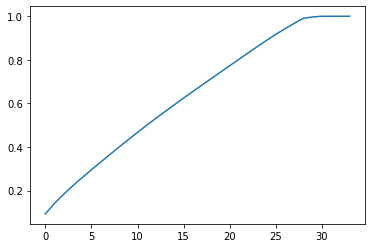

In [61]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import  StandardScaler

x1_train = StandardScaler().fit_transform(x_train)
pca=PCA()
pca.fit_transform(x1_train) 

plt.plot(pca.explained_variance_ratio_.cumsum())


for i,  x in enumerate(pca.explained_variance_ratio_.cumsum()):
  if x >0.95:
    print (f'Number of component cover over 95% is {i}')
    break

### Random Forest.



##### Step 1: Hyperparameter tuning. 

tune the max_depth hyperparameter using grid search. We have already tested the number of estimators hyperparameter for you. Note this section may take a while to run depending on how large your grid is. 



In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

depth = [4,8,16]
criterion = ["gini", 'entropy'] #default=”gini”
max_features =["sqrt", "log2"]  #  default=”auto”

# tune parameter using gredsearchCV

params = {'max_depth': depth,
          'max_features': max_features}

rf_base = RandomForestRegressor(random_state=42)
grid_search_rf_dt = GridSearchCV(rf_base, params, cv = 5)

%time
grid_search_rf_dt.fit(sx_train, sy_train)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 8, 16],
                         'max_features': ['sqrt', 'log2']})

In [107]:
grid_search_rf_dt.best_params_

{'max_depth': 16, 'max_features': 'sqrt'}

##### Step 2: Fitting RF
Fit the random forest on the training data using the parameters you computed above. Then make predictions on the test set, report the root mean squared error for the test set. 

In [77]:

clf = RandomForestRegressor(n_estimators=140, max_depth=16, max_features='sqrt')
clf.fit(sx_train, sy_train)
y_pred = clf.predict(sx_test)
train_y_pred = clf.predict(sx_train)

train_mse = mean_squared_error(train_y_pred, sy_train)
train_r2 = r2_score(train_y_pred,sy_train)

mse = mean_squared_error(y_pred, sy_test)
r2 = r2_score(y_pred,sy_test)

print(f'RF_train_MES:{train_mse}, RF_train r2 socre : {train_r2}' )
print(f'RF_test MES:{mse}, RF_test r2 socre : {r2}' )


RF_train_MES:0.1347427862920481, RF_train r2 socre : 0.9517774536875314
RF_test MES:0.44151078487673767, RF_test r2 socre : 0.8266018499242298


# Distributed Machine Learning with Apache Spark 

Apache Spark ML : good for Big Data,  classification, regression, clustering, collaborative filtering, dimensionality reduction, and underlying optimization primitives.

Reference [here](https://spark.apache.org/docs/latest/ml-guide.html)

### Initializing Spark Connection 


In [83]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 37 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkadm5srv-mit11 amd64 1.16-2ubuntu0.2 [49.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkadm5

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 70.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=118c5f117730d2b8e3626b93460420642a5842c1b49cd0fc80275fe4a4c402b9
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [84]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [85]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()


In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


###  Data for Spark ML 

Read the saved_csv (combined_data) into a spark dataframe. 

In [86]:

# "inferSchema" flag to True : the columns are the correct datatypes and not all strings

combined_data_sdf = spark.read.format("csv").load("combined_data.csv",inferSchema="true", header="true")
combined_data_sdf

DataFrame[video_id: string, comments_disabled: boolean, ratings_disabled: boolean, video_error_or_removed: boolean, likes_log: double, label: double, dislikes_log: double, comment_log: double, num_tags: int, desc_len: int, len_title: int, weekday_1: int, weekday_2: int, weekday_3: int, weekday_4: int, weekday_5: int, weekday_6: int, weekday_7: int, country_CA: int, country_FR: int, country_IN: int, country_US: int, category_1: int, category_10: int, category_15: int, category_17: int, category_19: int, category_2: int, category_20: int, category_22: int, category_23: int, category_24: int, category_25: int, category_26: int, category_27: int, category_28: int, category_29: int, category_30: int, category_43: int, category_44: int]

Just make sure everything looks good

In [87]:
combined_data_sdf.columns

['video_id',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'likes_log',
 'label',
 'dislikes_log',
 'comment_log',
 'num_tags',
 'desc_len',
 'len_title',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'country_CA',
 'country_FR',
 'country_IN',
 'country_US',
 'category_1',
 'category_10',
 'category_15',
 'category_17',
 'category_19',
 'category_2',
 'category_20',
 'category_22',
 'category_23',
 'category_24',
 'category_25',
 'category_26',
 'category_27',
 'category_28',
 'category_29',
 'category_30',
 'category_43',
 'category_44']

Print out the dataframe schema and verify the datatypes

In [88]:

combined_data_sdf.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- video_error_or_removed: boolean (nullable = true)
 |-- likes_log: double (nullable = true)
 |-- label: double (nullable = true)
 |-- dislikes_log: double (nullable = true)
 |-- comment_log: double (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- desc_len: integer (nullable = true)
 |-- len_title: integer (nullable = true)
 |-- weekday_1: integer (nullable = true)
 |-- weekday_2: integer (nullable = true)
 |-- weekday_3: integer (nullable = true)
 |-- weekday_4: integer (nullable = true)
 |-- weekday_5: integer (nullable = true)
 |-- weekday_6: integer (nullable = true)
 |-- weekday_7: integer (nullable = true)
 |-- country_CA: integer (nullable = true)
 |-- country_FR: integer (nullable = true)
 |-- country_IN: integer (nullable = true)
 |-- country_US: integer (nullable = true)
 |-- category_1: integer (nullable = true)
 |-

For Spark ML, create a single column feature 

VectorAssembler() to create a feature vector from all categorical and numerical features saved as “features”.


In [89]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [90]:

all_columns = combined_data_sdf.columns

Create a drop_columns to exclude for ML

In [91]:

drop_columns = ['video_id','label','len_title','desc_len','comments_disabled','ratings_disabled']

In [92]:
columns_to_use = [i for i in all_columns if i not in drop_columns]
columns_to_use

['video_error_or_removed',
 'likes_log',
 'dislikes_log',
 'comment_log',
 'num_tags',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'country_CA',
 'country_FR',
 'country_IN',
 'country_US',
 'category_1',
 'category_10',
 'category_15',
 'category_17',
 'category_19',
 'category_2',
 'category_20',
 'category_22',
 'category_23',
 'category_24',
 'category_25',
 'category_26',
 'category_27',
 'category_28',
 'category_29',
 'category_30',
 'category_43',
 'category_44']

Create a VectorAssembler object with columns you want to use. 

In [93]:
assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")
combined_data_sdf2 = assembler.transform(combined_data_sdf)

combined_data_sdf2.select('features','label').show(5)


+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|(34,[1,2,3,4,5,13...|12.267652105461218|
|(34,[1,2,3,4,11,1...|12.977850768461046|
|(34,[1,2,3,4,5,13...|13.086018844077508|
|(34,[1,2,3,4,11,1...|13.737790068520269|
|(34,[1,2,3,4,5,13...|11.861439196628254|
+--------------------+------------------+
only showing top 5 rows




Create a pipeline with many stages. *OPTIONAL*

In this step, we will create a pipeline with a single stage - the assembler. Fit the pipeline to your data and create the transformed dataframe and name it 'modified_data_sdf'.

In [94]:
from pyspark.ml import Pipeline


assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")

pipe = Pipeline(stages=[assembler])
model = pipe.fit(combined_data_sdf)
modified_data_sdf = model.transform(combined_data_sdf)
modified_data_sdf.show() 



+-----------+-----------------+----------------+----------------------+------------------+------------------+------------------+-----------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+
|   video_id|comments_disabled|ratings_disabled|video_error_or_removed|         likes_log|             label|      dislikes_log|      comment_log|num_tags|desc_len|len_title|weekday_1|weekday_2|weekday_3|weekday_4|weekday_5|weekday_6|weekday_7|country_CA|country_FR|country_IN|country_US|category_1|category_10|category_15|category_17|category_19|category_2|category_20|category_22|category_23|category_24|category_25|category_26|category_27|category_28|category_29|category_3

Now that we have the data in the format we need, we will create out train and test sets. Split into an 80-20 ratio between the train and test sets. Name these 'train_sdf' and 'test_sdf'

In [95]:
modified_data_sdf=modified_data_sdf.drop('video_id')
modified_data_sdf.printSchema()

root
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- video_error_or_removed: boolean (nullable = true)
 |-- likes_log: double (nullable = true)
 |-- label: double (nullable = true)
 |-- dislikes_log: double (nullable = true)
 |-- comment_log: double (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- desc_len: integer (nullable = true)
 |-- len_title: integer (nullable = true)
 |-- weekday_1: integer (nullable = true)
 |-- weekday_2: integer (nullable = true)
 |-- weekday_3: integer (nullable = true)
 |-- weekday_4: integer (nullable = true)
 |-- weekday_5: integer (nullable = true)
 |-- weekday_6: integer (nullable = true)
 |-- weekday_7: integer (nullable = true)
 |-- country_CA: integer (nullable = true)
 |-- country_FR: integer (nullable = true)
 |-- country_IN: integer (nullable = true)
 |-- country_US: integer (nullable = true)
 |-- category_1: integer (nullable = true)
 |-- category_10: integer (nullable = true)

In [96]:

train_sdf, test_sdf = combined_data_sdf2.randomSplit([0.8, 0.2], seed = 2018)

### Linear regression using Spark ML

Time to do the cool stuff, let's train a linear regression model to our data and try to predict the views again! This time, we will use "Big" data tools. Using Spark ML's linear regression, create a model, fit the training data. We will then see the summary stats for the model - the RMSE error, R2 score and other information you find useful. Look up the documentation online and try to understand how to implement this.

Firstly, train a model without any regularization!

In [97]:
from pyspark.ml.regression import LinearRegression

lr_regr = LinearRegression(featuresCol = 'features', labelCol = 'label')
lr_model=lr_regr.fit(train_sdf)




In [104]:
trainingSummary = lr_model.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)



RMSE: 0.803130
r2: 0.804727


In [103]:

predictions = lr_model.transform(test_sdf)
predictions.show(5)

# prediction column created


+--------+-----------------+----------------+----------------------+------------------+------------------+------------------+------------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+------------------+
|video_id|comments_disabled|ratings_disabled|video_error_or_removed|         likes_log|             label|      dislikes_log|       comment_log|num_tags|desc_len|len_title|weekday_1|weekday_2|weekday_3|weekday_4|weekday_5|weekday_6|weekday_7|country_CA|country_FR|country_IN|country_US|category_1|category_10|category_15|category_17|category_19|category_2|category_20|category_22|category_23|category_24|category_25|category_26|category_27|category_28|categor

In [115]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
rmse= evaluator.evaluate(predictions)
print(f"rmse on test data = {rmse}")

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
r2=r2_evaluator.evaluate(predictions)
print(f"R2 on test data = {r2}")

rmse on test data = 0.8105088859086372
R2 on test data = 0.8003816274937904


Add regularization : LASSO (L1), Ridge (L2) and elastic net (combination of L1 and L2) and different regularization hyperparameters when initializing 3 different regularized linear regression models. Compare these with each other and the non regularized regression done above.

In [116]:
# Compute predictions using each of the models

l1_model = LinearRegression(regParam=0.3, elasticNetParam=1).fit(train_sdf)
l2_model = LinearRegression(regParam=0.3, elasticNetParam=0).fit(train_sdf)
elastic_model = LinearRegression(regParam=0.3, elasticNetParam=0.5).fit(train_sdf)


l1_predictions = l1_model.transform(test_sdf)
l2_predictions = l2_model.transform(test_sdf)
elastic_net_predictions = elastic_model.transform(test_sdf)


test_rmse_l1 = l1_model.summary.rootMeanSquaredError
test_rmse_l2 = l2_model.summary.rootMeanSquaredError
test_rmse_elastic = elastic_model.summary.rootMeanSquaredError


In [117]:

print (f'test_rmse_l1: {test_rmse_l1}, test_rmse_l2 : {test_rmse_l2}, test_rmse_elastic: {test_rmse_elastic}')


test_rmse_l1: 0.9070627026044952, test_rmse_l2 : 0.8204104075473567, test_rmse_elastic: 0.856877112147261


### Random Forest Regression 

create a random forest regressor model, fit the training data and evaluate using RegressionEvaluator. 

In [118]:
from pyspark.ml.regression import RandomForestRegressor


rf_reg = RandomForestRegressor(featuresCol = 'features', labelCol = 'label')
rf_model = rf_reg.fit(train_sdf)
predictions = rf_model.transform(test_sdf)

predictions.show()


+--------+-----------------+----------------+----------------------+------------------+------------------+------------------+------------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+------------------+
|video_id|comments_disabled|ratings_disabled|video_error_or_removed|         likes_log|             label|      dislikes_log|       comment_log|num_tags|desc_len|len_title|weekday_1|weekday_2|weekday_3|weekday_4|weekday_5|weekday_6|weekday_7|country_CA|country_FR|country_IN|country_US|category_1|category_10|category_15|category_17|category_19|category_2|category_20|category_22|category_23|category_24|category_25|category_26|category_27|category_28|categor

In [120]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
r2_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2')

rmse = evaluator.evaluate(predictions)

r2=r2_evaluator.evaluate(predictions)
print(f"rmse ={rmse}, R2 on test data = {r2}")

rmse =0.7370048687019511, R2 on test data = 0.8349461484626118


In [121]:

train_rmse_rf = evaluator.evaluate(rf_model.transform(train_sdf)) 
test_rmse_rf = evaluator.evaluate(rf_model.transform(test_sdf))


In [122]:
train_rmse_rf,test_rmse_rf

(0.733962415982146, 0.7370048687019511)

### Dimensionality Reduction using PCA 

Steps for this section
1.   Initialize a PCA model
2.   Fit the model using the training data
3.   Get the PCA feature from the trained model
4.   Train a linear regression model using the PCA features
5.   Evaluate the performance on the test set 






In [123]:

from pyspark.ml.feature import PCA
# from pyspark.ml.feature import Normalizer

# normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=31, inputCol="features", outputCol="pca_features")

pca_model = pca.fit(train_sdf)

pca_train = pca_model.transform(train_sdf)
pca_test = pca_model.transform(test_sdf)

In [124]:
lr_regr_pca = LinearRegression(featuresCol = 'pca_features', labelCol = 'label')
lr_model_pca=lr_regr_pca.fit(pca_train)



print("RMSE: %f" % lr_model_pca.summary.rootMeanSquaredError)
print("r2: %f" % lr_model_pca.summary.r2)

RMSE: 0.803130
r2: 0.804727


In [125]:

predictions = lr_model.transform(pca_test)

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')

test_rmse_pca = evaluator.evaluate(predictions)
training_rmse_pca = evaluator.evaluate(lr_model.transform(pca_train))

In [126]:
test_rmse_pca,training_rmse_pca

(0.8105088859086372, 0.8031297417803742)